In [1]:
# import your standard packages
%run ../../global-tools/start.py

# import your local functions
sys.path.insert(1, '../local-tools/')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Seasonal Ekman Pumping

To isolate interior ekman pumping, this code follows https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2011JC007531

Need to still do alongshore wind stress at some point too...need local bathymetry for that...perhaps cartopy has it.

https://earthweb.ess.washington.edu/roe/Web_page_514/ESS514/Notes_files/MarshallPlumb_GulfStream.pdf

https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdQMstress1day.html

Still need to add in beta affect perhaps! See SI of chl 2016 paper

In [2]:
ds_wnd = xr.open_dataset('../data/NCEP_Wind/ncep_wind_processed.nc')
ds_wnd

<xarray.Dataset>
Dimensions:             (lat: 27, lon: 46, month: 12, season: 4, time: 497)
Coordinates:
  * lon                 (lon) float32 35.625 37.5 39.375 ... 118.125 120.0
  * lat                 (lat) float32 -19.9997 -18.095 ... 27.6186 29.5234
  * time                (time) datetime64[ns] 1979-01-01 ... 2020-05-01
  * season              (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    uwnd                (time, lat, lon) float32 ...
    vwnd                (time, lat, lon) float32 ...
    Wnd_sp              (time, lat, lon) float64 ...
    curl_tau            (time, lat, lon) float64 ...
    tau_x               (time, lat, lon) float64 ...
    tau_y               (time, lat, lon) float64 ...
    W_Ek                (time, lat, lon) float64 ...
    uwnd_seas_clim      (season, lat, lon) float64 ...
    uwnd_mon_clim       (month, lat, lon) float32 ...
    vwnd_seas_clim      (season, lat, lon) floa

In [3]:

var = ds_wnd.W_Ek_mon_clim

#######################################################
# get seasonal anomaly
# 0 = MAM, 1 = JJA, 2 = SON, 3 = DJF
seasonal_std_W_Ek = np.full([2,len(ds_wnd.lat),len(ds_wnd.lon)],np.nan)
for ss in range(2):
    if ss == 0:
        ind = [5,6,7,8,9,10] # Summer/Fall - -1 for index
        seasonal_std_W_Ek[ss,:,:] = np.nanstd(var[ind,:,:],0)
        
    elif ss == 1:
        ind = [0,1,2,3,4,11] # Winter/Spring
        seasonal_std_W_Ek[ss,:,:] = np.nanstd(var[ind,:,:],0)

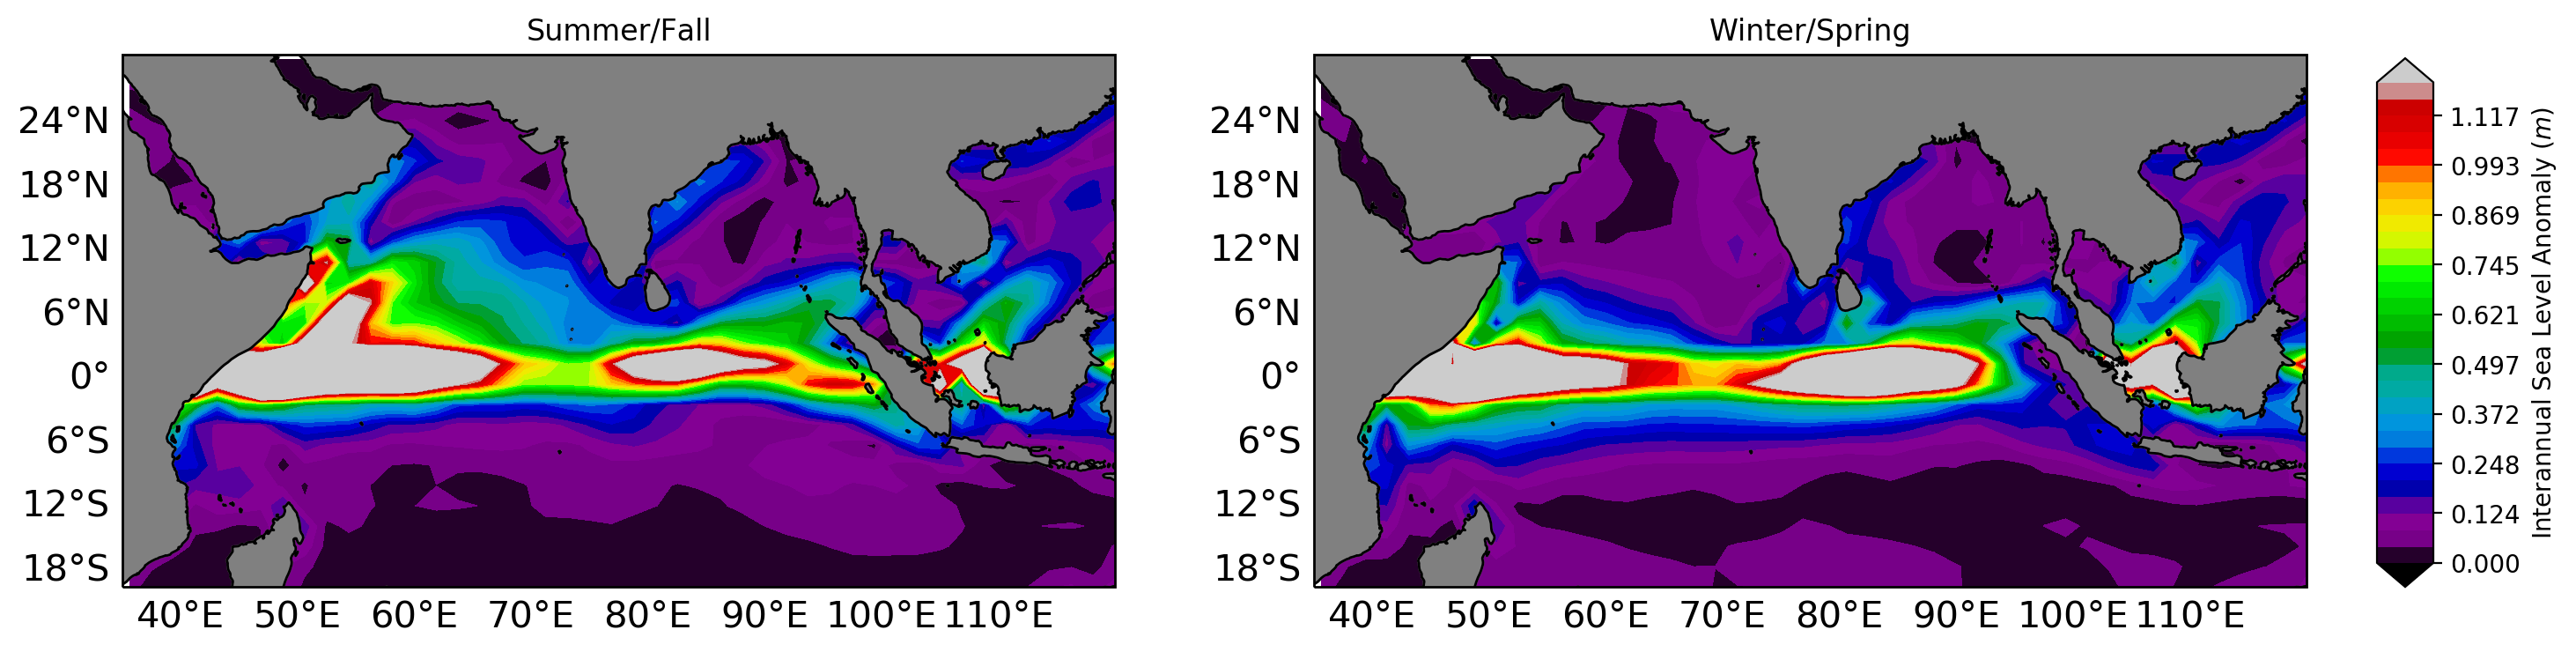

In [4]:

xx,yy = np.meshgrid(ds_wnd.lon,ds_wnd.lat)
cmin = 0
cmax = 1.2
cmap = plt.cm.nipy_spectral

# colorbar limits
levels = np.linspace(cmin, cmax, 30)
    
    
fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(16,4),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})

ax = axes[0]
cf = ax.contourf(xx,yy,seasonal_std_W_Ek[0,:,:]*86400,levels = levels,cmap = cmap, vmin = cmin, vmax = cmax, extend="both")
add_land(ax,[35,120,-20,30])
ax.set_title('Summer/Fall')
cf.set_clim(cmin, cmax)

ax = axes[1]
cf = ax.contourf(xx,yy,seasonal_std_W_Ek[1,:,:]*86400,levels = levels,cmap = cmap, vmin = cmin, vmax = cmax, extend="both")
add_land(ax,[35,120,-20,30])
ax.set_title('Winter/Spring')
cf.set_clim(cmin, cmax)

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Interannual Sea Level Anomaly ($m$)')


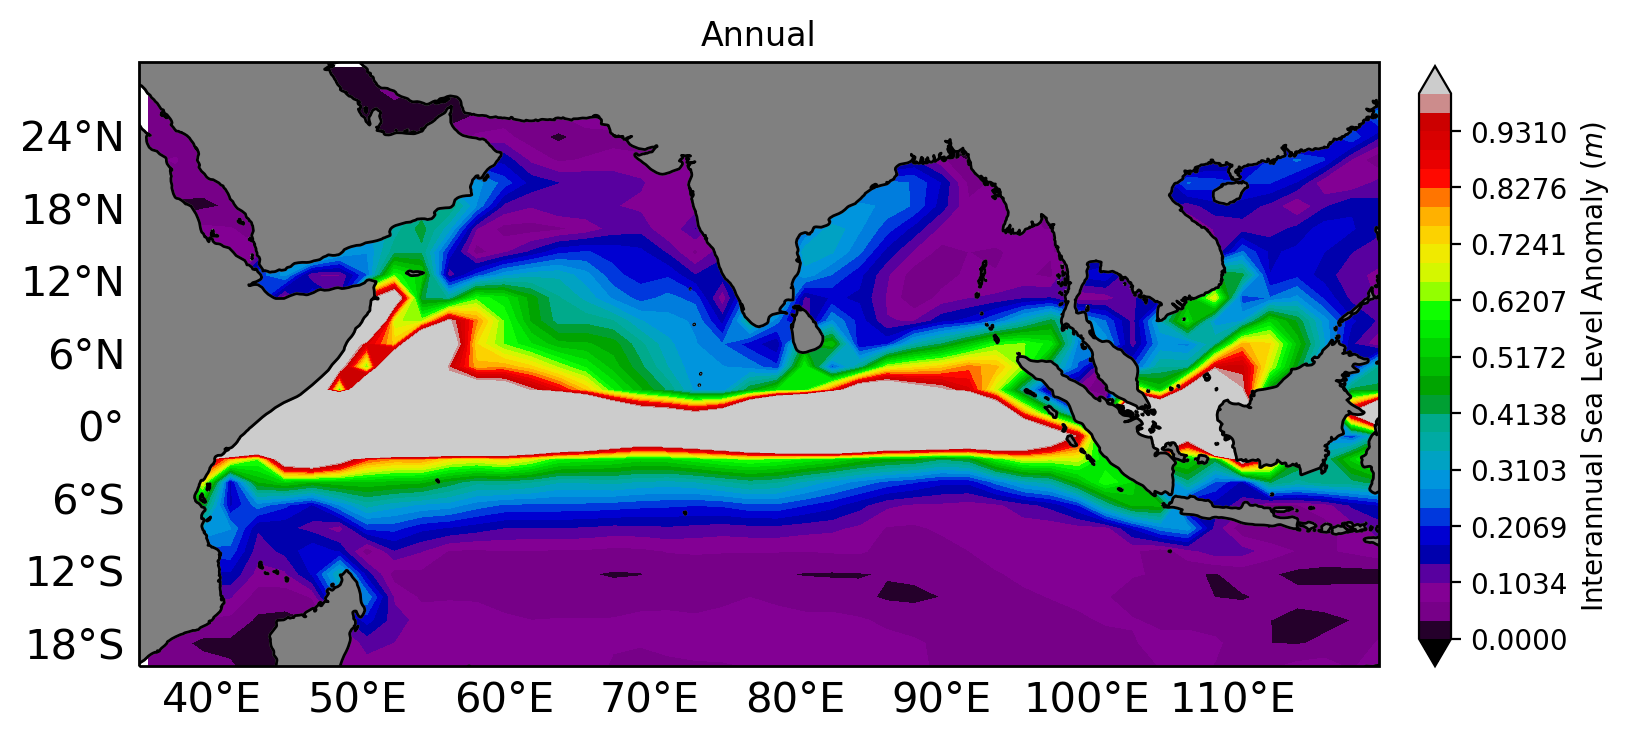

In [5]:
var = np.nanstd(ds_wnd.W_Ek_mon_clim,0)

xx,yy = np.meshgrid(ds_wnd.lon,ds_wnd.lat)
cmin = 0
cmax = 1
cmap = plt.cm.nipy_spectral

# colorbar limits
levels = np.linspace(cmin, cmax, 30)
    
    
fig, axes = plt.subplots(nrows = 1, ncols = 1,figsize=(8,4),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})

ax = axes
cf = ax.contourf(xx,yy,var*86400,levels = levels,cmap = cmap, vmin = cmin, vmax = cmax, extend="both")
add_land(ax,[35,120,-20,30])
ax.set_title('Annual')
cf.set_clim(cmin, cmax)


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Interannual Sea Level Anomaly ($m$)')

In [6]:
# group into summer/fall, winter/spring
# group into positive and negative iod years during 2 seasons


In [7]:
np.nanmax(seasonal_std_W_Ek[0,:,:])

3.992192796037589e-05

In [8]:
def latlon_to_xyz(lat,lon):
    """Convert angluar to cartesian coordiantes

    latitude is the 90deg - zenith angle in range [-90;90]
    lonitude is the azimuthal angle in range [-180;180] 
    """
    r = 6371 # https://en.wikipedia.org/wiki/Earth_radius
    theta = np.pi/2 - np.deg2rad(lat) 
    phi = np.deg2rad(lon)
    x = r * np.sin(theta) * np.cos(phi) # bronstein (3.381a)
    y = r * np.sin(theta) * np.sin(phi)
#     z = r * math.cos(theta)
    return [x,y]